# Build a Retrieval Augmented Generation (RAG) App

* RAG - q&a with grounding (e.g. context of pdfs)

Concepts
1. indexing - pipeline for ingesting data and indexing it for retrieval during RAG, done offline
    * load data: using document loaders
    * split: text splitters break large documents into smaller chunks (chunking). This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.
    * store: a place to store and index splits - use VectorStore and Embeddings model

2. retrieval - the RAG chain which takes the user input query at run time and retrieves the relevant data from the index
    * retrieve: Retriever used to get relevant splits
        * done by doing similarity comparison of query with documents
4. generation - part of RAG chain that takes the retrieved context and pass to model

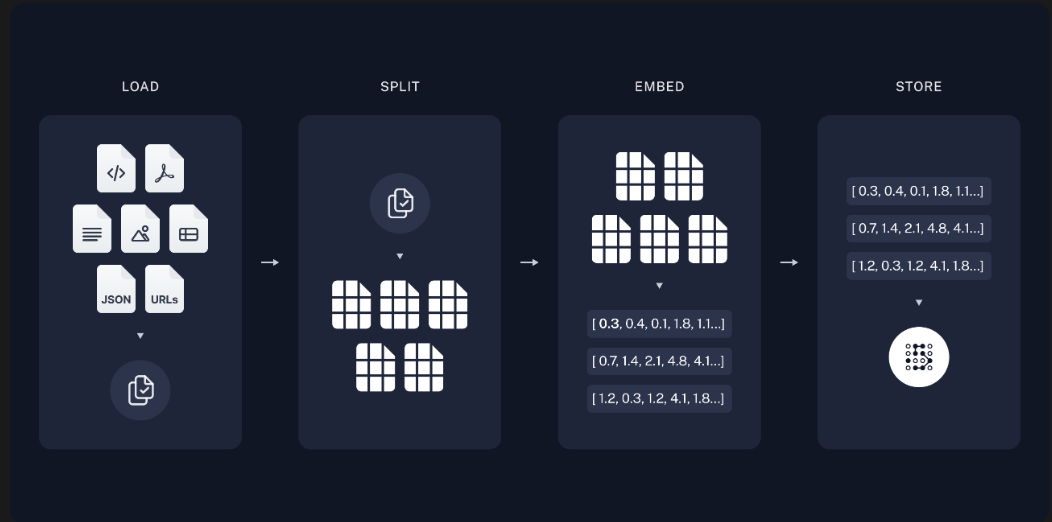

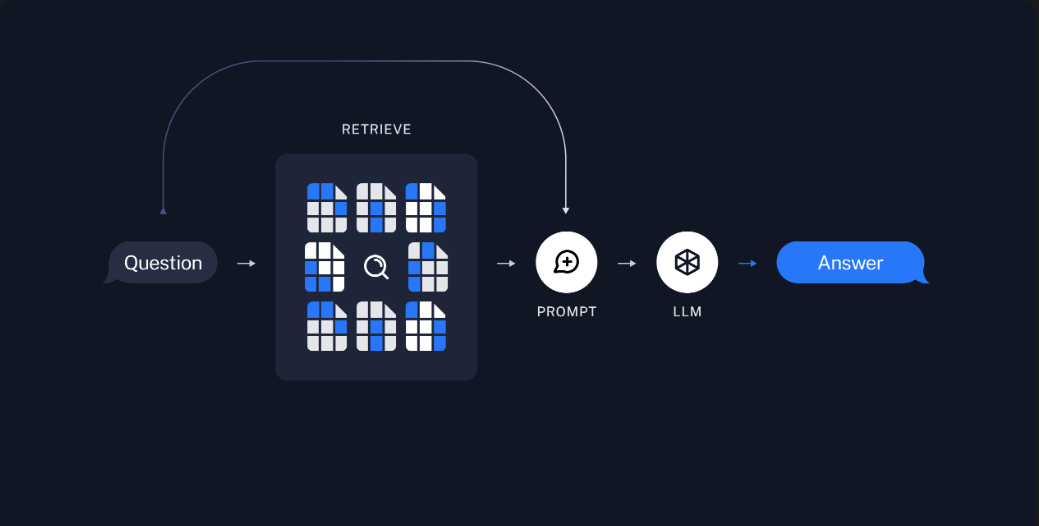

In [1]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4o-mini')

 ········


/Users/I748920/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In this guide we’ll build an app that answers questions about the content of a website. The specific website we will use is the LLM Powered Autonomous Agents blog post by Lilian Weng, which allows us to ask questions about the contents of the post.
https://lilianweng.github.io/posts/2023-06-23-agent/

In [6]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


## 1. load data

In [ ]:
# example with txt file

from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

# Load the document, split it into chunks, embed each chunk and load it into the vector store.
raw_documents = TextLoader('state_of_the_union.txt').load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(raw_documents)

In [8]:
# Load, chunk and index the contents of the blog.

url_link = "https://lilianweng.github.io/posts/2023-06-23-agent/"

loader = WebBaseLoader(
    web_paths=(url_link,),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()

In [15]:
len(docs), len(docs[0].page_content)

(1, 43131)

In [33]:
docs[0].page_content[:100], docs[0].metadata

('\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |',
 {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'})

loads all the text in the website into docs

WebBaseLoader is a type of document loader
from langchain_community.document_loaders import has many different types of loaders

A Document is an object with some page_content (str) and metadata (dict).

WebBaseLoader, which uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text. 
In this case only HTML tags with class “post-content”, “post-title”, or “post-header” are relevant, so we’ll remove all others.

docs for document loaders: https://python.langchain.com/v0.2/docs/how_to/#document-loaders

## 2. indexing - split

In [52]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
splits = text_splitter.split_documents(docs)

print(len(splits))
print(splits[:3])

type(splits[0])

66
[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn f

langchain_core.documents.base.Document

In [ ]:
chunk_size - num of characters for each chunk, cannot just check using len() since its char
chunk_overlap - n characters of overlap between chunks. 

In [45]:
len(splits[1].page_content)

609

output of splits are type class Document as well

Our loaded document is over 42k characters long. This is too long to fit in the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we’ll split the Document into chunks for embedding and vector storage. This should help us retrieve only the most relevant bits of the blog post at run time.


chunking overlap **  The overlap helps mitigate the possibility of separating a statement from important context related to it.

We use the RecursiveCharacterTextSplitter, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases. https://api.python.langchain.com/en/latest/text_splitters_api_reference.html

add_start_index=True so that the character index at which each split Document starts within the initial Document is preserved as metadata attribute “start_index”.

In [50]:
splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8}

TextSplitter is subclass of DocumentTransformers
https://python.langchain.com/v0.2/docs/how_to/#text-splitters

## 3. indexing - store

Now we need to index our 66 text chunks so that we can search over them at runtime. The most common way to do this is to embed the contents of each document split and insert these embeddings into a vector database (or vector store). When we want to search over our splits, we take a text search query, embed it, and perform some sort of “similarity” search to identify the stored splits with the most similar embeddings to our query embedding. The simplest similarity measure is cosine similarity — we measure the cosine of the angle between each pair of embeddings (which are high dimensional vectors).

We can embed and store all of our document splits in a single command using the Chroma vector store and OpenAIEmbeddings model.

In [55]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

In [61]:
vectorstore.embeddings

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x13fa2a130>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x13fcd59a0>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

Embeddings: Wrapper around a text embedding model, used for converting text to embeddings.
https://python.langchain.com/v0.2/docs/how_to/embed_text/
https://python.langchain.com/v0.2/docs/integrations/text_embedding/

VectorStore: Wrapper around a vector database, used for storing and querying embeddings.
https://python.langchain.com/v0.2/docs/how_to/vectorstores/
https://python.langchain.com/v0.2/docs/integrations/vectorstores/

# 4. Retrieve

The most common type of Retriever is the VectorStoreRetriever, which uses the similarity search capabilities of a vector store to facilitate retrieval. Any VectorStore can easily be turned into a Retriever with VectorStore.as_retriever():

In [68]:
# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

In [70]:
# e.g. 

retrieved_docs = retriever.invoke("What are the approaches to Task Decomposition?")

len(retrieved_docs)

6

In [72]:
retrieved_docs[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.')

https://python.langchain.com/v0.2/docs/how_to/#retrievers
https://python.langchain.com/v0.2/docs/integrations/retrievers/
https://python.langchain.com/v0.2/api_reference/core/retrievers/langchain_core.retrievers.BaseRetriever.html

alternative Retrievers

MultiQueryRetriever generates variants of the input question to improve retrieval hit rate.
MultiVectorRetriever instead generates variants of the embeddings, also in order to improve retrieval hit rate.
Max marginal relevance selects for relevance and diversity among the retrieved documents to avoid passing in duplicate context.
Documents can be filtered during vector store retrieval using metadata filters, such as with a Self Query Retriever.

# 5. Generate

In [74]:
model

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x10d404400>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x10d40dd90>, root_client=<openai.OpenAI object at 0x10afe9760>, root_async_client=<openai.AsyncOpenAI object at 0x10d404430>, model_name='gpt-4o-mini', openai_api_key=SecretStr('**********'), openai_proxy='')

In [76]:
# get a sample rag prompt

from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [78]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [92]:
example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages[0].content

"You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:"

In [94]:
# using print will get a nicer formatting
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: filler question 
Context: filler context 
Answer:


In [107]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is the process of breaking down complex tasks into smaller, more manageable steps. This approach is often facilitated by techniques like Chain of Thought (CoT), where models are prompted to think step by step, improving their performance on intricate tasks. Additionally, methods like Tree of Thoughts expand on this by exploring multiple reasoning possibilities at each step.'

As we've seen above, the input to prompt is expected to be a dict with keys "context" and "question". So the first element of this chain builds runnables that will calculate both of these from the input question:

retriever | format_docs passes the question through the retriever, generating Document objects, and then to format_docs to generate strings;
RunnablePassthrough() passes through the input question unchanged.

In [113]:
# alternative

message_input = {
    'context': retriever,
    'question': RunnablePassthrough()
}

rag_chain = message_input | prompt | model | StrOutputParser()
rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is the process of breaking down complex tasks into smaller, more manageable steps. This can be achieved through techniques like Chain of Thought (CoT), where a model is prompted to think step by step, or by using specific instructions and human inputs. It helps in enhancing model performance by making the reasoning process clearer and tasks easier to manage.'

"context": retriever | format_docs vs 'context': retriever

in second case, the docs retrieved from Retriever are Document objects instead of strings
but the first case, the function format_docs converts the retrieved document to strings
though it can still work without the conversion

The last steps of the chain are llm, which runs the inference, and StrOutputParser(), which just plucks the string content out of the LLM's output message.

In [116]:
# e.g. 

retrieved_docs = retriever.invoke("What are the approaches to Task Decomposition?")

len(retrieved_docs)

6

In [118]:
retrieved_docs[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.')

In [126]:
retrieved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task u

In [124]:
[doc.page_content for doc in retrieved_docs]

['Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.',
 'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The mo

In [120]:
format_docs(retrieved_docs)

'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The mode

In [128]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

response = rag_chain.invoke("What is Task Decomposition?")

In [136]:
response

'Task decomposition is the process of breaking down complex tasks into smaller, more manageable steps. This technique is often enhanced by methods like Chain of Thought (CoT), which encourages step-by-step reasoning to improve model performance. It can be achieved through simple prompts, task-specific instructions, or human inputs.'

if you want to implement a way that enables user to see the documents that were used toanswer the question - need to use create_retrieval_chain

In [142]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

response = rag_chain.invoke({"input": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down a complicated task into smaller, manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance model performance by guiding the model to think step-by-step and explore multiple reasoning possibilities at each stage. This approach helps in simplifying complex tasks and improving the interpretability of the model's reasoning process.


In [158]:
question_answer_chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), config={'run_name': 'format_inputs'})
| ChatPromptTemplate(input_variables=['context', 'input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\n{context}")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x10d404400>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x10d40dd90>, root_client=<openai.OpenAI object at 0x10afe9760>, root_async_client=<openai.AsyncOpenAI object at 0x10d404430>, model_name='gpt-4o-mini', openai_api_key=SecretStr(

In [144]:
for document in response["context"]:
    print(document)
    print()

page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}

page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS 

choosing a model
* ChatModel: An LLM-backed chat model. Takes in a sequence of messages and returns a message.
* LLM: A text-in-text-out LLM. Takes in a string and returns a string.

Customizing the prompt
As shown above, we can load prompts (e.g., this RAG prompt) from the prompt hub. The prompt can also be easily customized:

In [150]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

"Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts facilitate this by encouraging the model to think step-by-step or explore multiple reasoning possibilities. This helps in enhancing performance and understanding the model's thinking process. Thanks for asking!"

Summary 

We've covered the steps to build a basic Q&A app over data:

Loading data with a Document Loader
Chunking the indexed data with a Text Splitter to make it more easily usable by a model
Embedding the data and storing the data in a vectorstore
Retrieving the previously stored chunks in response to incoming questions
Generating an answer using the retrieved chunks as context
There’s plenty of features, integrations, and extensions to explore in each of the above sections. Along from the Go deeper sources mentioned above, good next steps include:

Return sources: Learn how to return source documents
Streaming: Learn how to stream outputs and intermediate steps
Add chat history: Learn how to add chat history to your app
Retrieval conceptual guide: A high-level overview of specific retrieval techniques
Build a local RAG application: Create an app similar to the one above using all local components


** note that the model inferences and vectorstore embeddings are not local, the commands make API calls to OpenAI servers

Code snippet: vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

The code snippet you provided is not entirely local because it depends on OpenAIEmbeddings(), which typically requires an API call to OpenAI's servers to generate embeddings.

Here's the breakdown:

What Happens in the Code:
Chroma.from_documents: This creates a vector store using Chroma, which can store embeddings for your documents and allow you to perform similarity searches. Chroma itself can be run locally.
OpenAIEmbeddings(): This is likely using OpenAI's API to generate embeddings for the documents. This means that the text is sent to OpenAI's servers, where the embeddings are computed and then returned to your local machine.

Local vs. Non-Local:
Non-Local: Since OpenAIEmbeddings() relies on an external API (OpenAI), this part of the process is not local. Your data is being processed on OpenAI's servers.
Local: If you were to use an embedding model that runs entirely on your local machine (e.g., using a local instance of HuggingFaceEmbeddings with a model downloaded to your device), then the entire process could be considered local.